In [2]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
from scipy.spatial.distance import cdist
from src.codons import get_stop_codon_info
import src.tools as tools

%load_ext autoreload
%autoreload 2


In [3]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

In [4]:
if not os.path.exists('../data/stop_codon.csv'):
    fn_dir = '../data/ncbi/genomes'
    fa_dir = '../data/prodigal'

    # genome_ids = [os.path.basename(path).replace('.fn', '') for path in glob.glob(f'{fn_dir}/*')]
    genome_ids = arf1_df.genome_id.unique() 

    stop_codon_df = list() 
    for genome_id in tqdm(genome_ids, 'Collecting stop codon data...'):
        row = {'genome_id':genome_id}
        fn_path = os.path.join(fn_dir, f'{genome_id}.fn')
        fa_path = os.path.join(fa_dir, f'{genome_id}.fa')
        row.update(get_stop_codon_info(fn_path=fn_path, fa_path=fa_path))
        stop_codon_df.append(row)

    stop_codon_df = pd.concat(stop_codon_df)
    stop_codon_df['total'] = stop_codon_df.TAG + stop_codon_df.TAA + stop_codon_df.TGA 
    stop_codon_df.to_csv('../data/stop_codon.csv')
else:
    stop_codon_df = pd.read_csv('../data/stop_codon.csv', index_col=0)

arf1_df['tag_percent'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id').TAG.first())
stop_codon_df = stop_codon_df[stop_codon_df.genome_id.isin(arf1_df.genome_id.unique())].copy()
for field in ['has_pyl', 'order', 'genus']:
    stop_codon_df[field] = stop_codon_df['genome_id'].map(arf1_df.groupby('genome_id')[field].first())

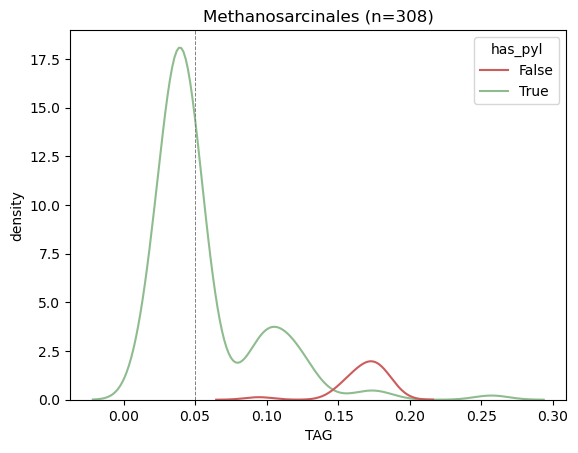

In [5]:
fig, ax = plt.subplots()

stop_codons = ['TAA', 'TGA', 'TAG']
palette = {True:'darkseagreen', False:'indianred'}

figure_df = stop_codon_df.copy()
figure_df = figure_df[figure_df.order == 'Methanosarcinales'].copy()
figure_df['n'] = figure_df.TAA + figure_df.TGA + figure_df.TAG
for stop_codon in stop_codons: # Get the frequencies of each stop codon. 
    figure_df[stop_codon] = figure_df[stop_codon] / figure_df['n']

sns.kdeplot(figure_df, x='TAG', hue='has_pyl', palette=palette)
ax.set_ylabel('density')
ax.axvline(x=0.05, ls='--', color='gray', lw=0.7)
ax.set_title(f'Methanosarcinales (n={len(figure_df)})')

plt.show()

# Among Pyl+ archaea, when the TAG content drops below 5%, the extension length spikes. This seems like a reasonable threshold for 
# choosing organisms which might have aRF1 changes. 
 
# When the TAG content is higher, the extension lengths are generally lower. In this scenario, we might not expect the 
# release factor to look very different. Genomes are robust to Pyl incorporation and stop codon readthrough. 

# When the TAG content is lower, extension lengths are higher. In these genomes, it may
# be the case that the genomes have fully adapted to frequent Pyl; these are probably the "recoded" genomes.

In [9]:
methanosarcinales_arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].copy()
FASTAFile().from_df(methanosarcinales_arf1_df).write('../data/methanosarcinales_arf1.fa')
tools.make_itol_annotation_file(methanosarcinales_arf1_df, field='tag_percent', path='../data/methanosarcinales_arf1_tree_annotation.txt')

In [29]:
# Downloaded and ran Prodigal on two genomes of Methanosarcina which (1) had Pyl (2) lost Pyl, and (3) 
# had their TAG usage revert back to the original form. If modifications in the release factor do play a role in 
# total re-coding, we would expect specific, conserved changes between aRF1 of these organisms and their closest relatives. 

# First, use MMSeqs pairwise alignment to find the Methanosarcina sequences which are closest in identity to the 


In [20]:
# aRF1 IDs:
# GCA_017883485.1 JADGNM010000028.1_7
# GCA_003164755.1 PLUB01000075.1_62

arf1_df = [FASTAFile().from_fasta('../data/data-2/GCA_003164755.1.fa').to_df()]
arf1_df += [FASTAFile().from_fasta('../data/data-2/GCA_017883485.1.fa').to_df()]
arf1_df = pd.concat(arf1_df, ignore_index=False)
arf1_df = arf1_df.loc[['JADGNM010000028.1_7', 'PLUB01000075.1_62']]
arf1_df

,description,seq
id,,
JADGNM010000028.1_7,# 6370 # 7617 # -1 # ID=162_7;partial=00;start...,MTEQSAHEKYEFKKKLESLRDEKGRGTELISLYIPPDKQIFDVTNQ...
PLUB01000075.1_62,# 73847 # 75094 # -1 # ID=113_62;partial=00;st...,MTEQSAHQRYEFKKKLESLRDKKGRSTELITLYIPLDKQIYDVTNQ...


In [21]:
for seq in arf1_df.seq:
    print(seq)

MTEQSAHEKYEFKKKLESLRDEKGRGTELISLYIPPDKQIFDVTNQLKEEHGQAANIKSKLTRTNVQGAIESLLSRLRYLNKVPENGIVYFTGAVDIGANKTSMESEVIVPPEPITVYKYHCDSTFHLEPLEDMLKDKNTFGLLVLDRREATVGLLVGKRIQAFRHLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDASSEIFLAIDHKDLKGILIGGPSPTKEEFYAGEFLHHELQKKILGLFDISYTDESGLSELLNAAGDKLQDLELMGQKNAVKAFFKELISDSGKVAYGEAQVRANLEINAVEMLLLSEDLRAERVTTKCSVCGYENKWTRRWKPGESAPTAGNCPKCGSSLDVTDVTDIVDEFSALADKSNAKVVFVSTDFDEGSQLMNAFGGMAAILRYNTGV*
MTEQSAHQRYEFKKKLESLRDKKGRSTELITLYIPLDKQIYDVTNQLKEEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTNMESEVIIPPEPITAYKYHCNSTFYLEPLEDMLKDKNTFGLLVLDRREATVGLLVGKRIQAFRHLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEIFLAIDHKDLKGVLIGGPSPTKEEFYAGEFLHHELQRKIIGLFDISYTDESGLPELLNAAGEKLQGLELMGQKNAVKAFFKELISDSGKVAYGETQVRANLEINAVEMLLLSEDLRAERVTTKCSVCGYENKWTRRWKPGESAPTAGNCPECGSSIDVTDVTDIVDELSALADKSNAKVTFVSTDFDEGSQLMNAFGGIAAILRYNTGV*
